# ESC-25 - Audio Classification

## Imports

In [1]:
import os
import datetime
from pathlib import Path
from os import path
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
import librosa.display
import random



In [2]:
tf.__version__

'2.3.0'

## Data prep

Click the following link to get the dataset into your Google Drive (shared from Nigel's Google Drive)

https://drive.google.com/drive/folders/1O-XrrhwJMrsmbyVd_MQqg533HejDblSZ?usp=sharing

### Get Access to Google Drive
1. Run the cell below
2. Click on the link that appears
3. Select your Google account and allow access
4. Paste the access code into box below & hit <kbd>Enter</kbd>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
ROOT_DIR = Path("/content/gdrive/My Drive/")
PATH_ESC25 = ROOT_DIR/"ESC-25/"

print(os.path.exists(PATH_ESC25))

True


In [5]:
!ls "{PATH_ESC25}"

bluefruit  category_label  esc-25.pickle  test_data  train_data


# Read the Data

In [6]:
sound_filepaths = []
for filepath in Path(PATH_ESC25/'train_data').rglob('*.wav'):
    cat = path.dirname(filepath).split("/")[-1]
    sound_filepaths.append((str(filepath), cat))


In [7]:
sound_filepaths[0]

('/content/gdrive/My Drive/ESC-25/train_data/car_horn/2-54086-A-43.wav',
 'car_horn')

In [8]:
def extract_feature(filename):
    y, sr = librosa.load(filename, sr=44100)  

    S = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_mels=128, n_fft=1024, fmin=20.0, fmax=11025.0)
    S = librosa.power_to_db(S, top_db=80)
    return S[ :, 0:431, np.newaxis]


def get_feature_set(filedata):
    number_of_rows = len(filedata)
    processed_rows = 0
    validate_x = []
    validate_cat = []
    train_x = []
    train_cat = []
    i = 0

    for filename, cat in filedata:
        if i%5 != 0:
            train_x.append(extract_feature(filename))
            train_cat.append(cat)
        else:
            validate_x.append(extract_feature(filename))
            validate_cat.append(cat)
        i += 1

        processed_rows += 1  
        clear_output(wait=True)
        progress = float(100 * processed_rows) / number_of_rows
        print(f"Current process: {progress:.2f}%")

    le = LabelEncoder()
    train_y = to_categorical(le.fit_transform(np.array(train_cat)))
    validate_y = to_categorical(le.fit_transform(np.array(validate_cat)))

    return np.array(train_x), train_y, np.array(validate_x), validate_y, le.classes_

In [9]:
train_x, train_y, validate_x, validate_y, class_labels = get_feature_set(sound_filepaths)

Current process: 100.00%


In [10]:
print(train_x.shape)
print(train_y.shape)
print(validate_x.shape)
print(validate_y.shape)

(800, 128, 431, 1)
(800, 25)
(201, 128, 431, 1)
(201, 25)


#### Save data

In [11]:
save_data = open(f"{PATH_ESC25}/esc-25.pickle", "wb")
pickle.dump((train_x, train_y, validate_x, validate_y, class_labels), save_data)
save_data.close()

## Building the model

In [12]:
train_x, train_y, validate_x, validate_y, class_labels = pickle.load(open(f"{PATH_ESC25}/esc-25.pickle", "rb"))

In [13]:
class_labels

array(['breathing', 'car_horn', 'cat', 'chainsaw', 'chirping_birds',
       'clapping', 'coughing', 'cow', 'crickets', 'dog',
       'door_wood_knock', 'engine', 'frog', 'glass_breaking', 'hen',
       'laughing', 'rain', 'rooster', 'sheep', 'siren', 'sneezing',
       'snoring', 'thunderstorm', 'vacuum_cleaner', 'wind'], dtype='<U15')

In [8]:
train_x.shape

(800, 128, 431, 1)

In [14]:
np.random.seed(23)
random.seed(13)
tf.random.set_seed(124)

num_epochs = 50
num_batch_size = 32

num_labels = len(train_y[0])

input_layer = Input(shape=train_x.shape[1:])
reshape_layer = Conv2D(filters=3, kernel_size=3, strides=1, input_shape=(train_x.shape[1:]))
base_model = ResNet50(input_shape=(128,431,3), weights='imagenet', include_top=False)
base_model.trainable = True


out = ZeroPadding2D(1)(input_layer)
out = reshape_layer(out)
out = base_model(out)

ap = GlobalAveragePooling2D()(out)
mp = GlobalMaxPool2D()(out)
out = Concatenate()([ap,mp])
out = Flatten()(out)
out = BatchNormalization()(out)
out = Dropout(0.25)(out)
out = Dense(512, activation='relu')(out)
out = BatchNormalization()(out)
out = Dropout(0.5)(out)
predictions = Dense(num_labels, activation='softmax')(out)

model = Model(inputs = input_layer, outputs = predictions)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 431, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 130, 433, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 431, 3)  30          zero_padding2d[0][0]             
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 4, 14, 2048)  23587712    conv2d[0][0]                     
______________________

In [21]:
import sys
sys.path.insert(0, str(PATH_ESC25))
from bluefruit.tf_utils import DoubleCosineDecay, AugmentedData, show_spectro, plot_hist

learning_rate = DoubleCosineDecay(
    max_lr=3e-4,
    total_batches=num_epochs*len(train_y)//num_batch_size,
    )

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)


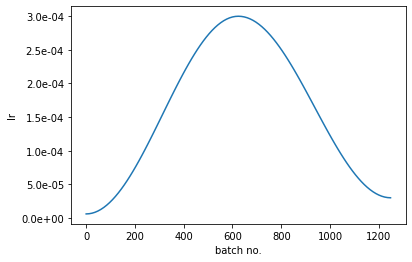

In [16]:
learning_rate.plot()

## Training

In [17]:
augmented_train = AugmentedData(train_x, train_y, num_batch_size, mixup=True, roll=True, freq_mask=True, mask_height=20)

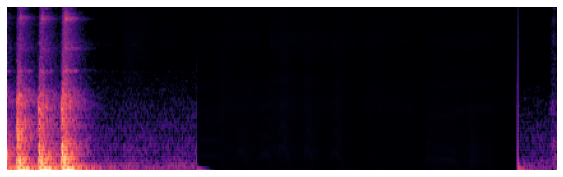

In [18]:
atrain = augmented_train[15]
spectros = atrain[0]
show_spectro(spectros[0])

In [20]:
hist = model.fit(augmented_train, epochs=num_epochs, \
          validation_data=(validate_x, validate_y), verbose=1)

Epoch 1/50
25/25 [==============================] - 10s 380ms/step - loss: 3.1393 - accuracy: 0.2562 - val_loss: 3.6422 - val_accuracy: 0.1592
Epoch 2/50
25/25 [==============================] - 10s 387ms/step - loss: 2.8934 - accuracy: 0.3162 - val_loss: 2.5759 - val_accuracy: 0.2786
Epoch 3/50
25/25 [==============================] - 10s 388ms/step - loss: 2.7065 - accuracy: 0.3837 - val_loss: 2.5633 - val_accuracy: 0.2935
Epoch 4/50
25/25 [==============================] - 10s 390ms/step - loss: 2.6349 - accuracy: 0.3887 - val_loss: 2.4655 - val_accuracy: 0.3433
Epoch 5/50
25/25 [==============================] - 10s 388ms/step - loss: 2.4513 - accuracy: 0.4350 - val_loss: 2.4001 - val_accuracy: 0.3582
Epoch 6/50
25/25 [==============================] - 10s 392ms/step - loss: 2.5563 - accuracy: 0.4038 - val_loss: 2.5753 - val_accuracy: 0.3483
Epoch 7/50
25/25 [==============================] - 10s 392ms/step - loss: 2.2705 - accuracy: 0.4613 - val_loss: 1.9421 - val_accuracy: 0.4677

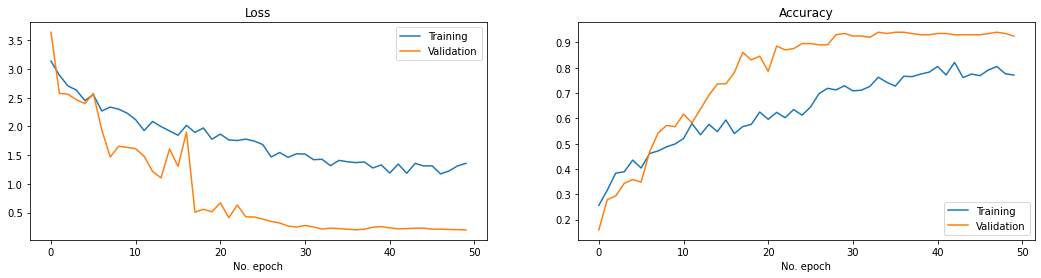

Max validation accuracy: 94.03% at epoch: 34


In [25]:
plot_hist(hist)
print(f"Max validation accuracy: {np.amax(hist.history['val_accuracy'])*100:0.2f}% at epoch: {np.argmax(hist.history['val_accuracy'])+1}")

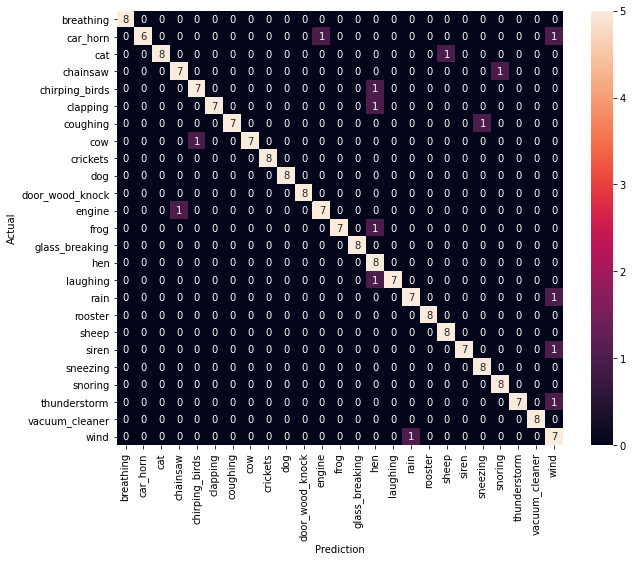

In [23]:
import seaborn as sns
pred = np.argmax(model.predict(validate_x), axis=1)
expected = np.argmax(validate_y, axis=1)
confusion_mtx = tf.math.confusion_matrix(expected, pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_labels, yticklabels=class_labels, 
            annot=True, fmt='g', vmin=0, vmax=5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

#### Optional - save model

In [38]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
model.save(f"{ROOT_DIR}/esc-25-model-{timestamp}") 

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/esc-25-model-10-12-20-09-27/assets


### Test TF Model

In [72]:
model.predict(extract_feature(f"{PATH_ESC25}/test_data/dog.wav")[np.newaxis,...])

array([[4.0786434e-02, 5.3215023e-02, 1.3310510e-03, 5.8419479e-05,
        1.1217946e-02, 9.1354066e-04, 7.2557130e-04, 2.6169186e-03,
        1.1325814e-01, 3.5536933e-01, 1.8811023e-03, 1.1966471e-03,
        2.7663033e-02, 4.2633217e-02, 1.7887318e-03, 5.0281533e-03,
        1.7061800e-03, 1.4833286e-02, 8.3116385e-05, 2.6535448e-03,
        2.9404816e-01, 1.8372025e-02, 8.1936689e-03, 8.8609078e-05,
        3.3816422e-04]], dtype=float32)

In [60]:
import glob
from pathlib import Path
from os import path



def get_human_readable_output(output):
    results = [
        'breathing', 'car_horn', 'cat',
        'chainsaw', 'chirping_birds',
        'clapping', 'coughing', 'cow',
        'crickets', 'dog', 'door_wood_knock',
        'engine', 'frog', 'glass_breaking',
        'hen', 'laughing', 'rain', 'rooster',
        'sheep', 'siren', 'sneezing',
        'snoring', 'thunderstorm',
        'vacuum_cleaner', 'wind'
    ]

    output = list(output[0])

    largest = max(output)
    index = output.index(largest)
    return results[index], f"({largest * 100.:.2f}%)"

def infer(filename):
    # generate spectrogram
    spectro = extract_feature(filename)
    # add a dummy "batch" dimension to the front of the tensor
    spectro = spectro[np.newaxis, ...]
    preds = model.predict(spectro)
    return get_human_readable_output(preds)

In [1]:
infer(f"{PATH_ESC25}/test_data/dog.wav")

NameError: ignored

In [65]:
infer(f"{PATH_ESC25}/test_data/vacuum.wav")

('vacuum_cleaner', '(97.75%)')

In [66]:
infer(f"{PATH_ESC25}/test_data/chirping_birds.wav")

('laughing', '(77.44%)')

In [103]:
import ipywidgets as widgets
%matplotlib inline

In [130]:
btn_upload = widgets.FileUpload(multiple=False)
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

out_pl = widgets.Output()
out_pl.clear_output()

def on_click_classify(change):
    lbl_pred.value = '...'
    with open('tmp.wav', "wb") as f:
        f.write(btn_upload.data[-1])
        
    out_pl.clear_output() #this should delete last spectro - why doesn't it?

    spectro = extract_feature('tmp.wav')
    preds = model.predict(spectro[np.newaxis, ...])
    get_human_readable_output(preds)
    lbl_pred.value = str(get_human_readable_output(preds))

    with out_pl:
        fig = plt.figure()

    ax = fig.gca()
    spectro = np.fliplr(np.rot90(spectro[:, :, 0], 2))
    ax.axis('off')
    ax.imshow(spectro, cmap='magma')


btn_run.on_click(on_click_classify)

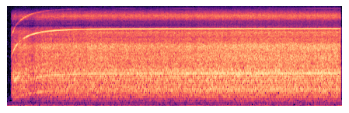

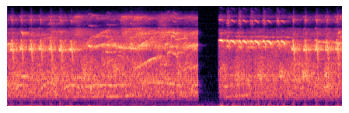

In [131]:
widgets.VBox([widgets.Label('Select your .wav file:'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Convert to TFLite

In [67]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [68]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmplx3ru27g/assets


In [69]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
filename = f"{ROOT_DIR}/esc-25-model-{timestamp}.tflite"
with open(filename, "wb") as f:
    f.write(tflite_model)
print(filename)

/content/gdrive/My Drive/esc-25-model-10-12-20-14-02.tflite


# Results

- Summarise important results such as different things you tried & how it affected accuracy for example

# Conclusions

- Summarise what you learned from this experiment